In [343]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
import string

def lemma(row):
    lemma = wnl.lemmatize(row['token'], row['pos_simple'])
    return lemma

def data_framer(workset_id, search_term):
    conn = http.client.HTTPSConnection("tools.htrc.illinois.edu")
    headers = { 'Content-Type': "application/json" }
    conn.request("GET", f"/ef-api/worksets/{workset_id}/volumes", headers=headers)
    res = conn.getresponse()
    data = res.read()
    data = json.loads(data.decode("utf-8"))
    dt = pd.DataFrame()
    print("The volumes included in this dataset are:")
    for volume in data['data']:
        print(volume['htid'],volume['metadata']['title'].title().translate(str.maketrans('', '', string.punctuation)))
    for vol in data['data']:
        htid = vol['htid']
        page_list = []
        title = vol['metadata']['title']
        title = title.translate(str.maketrans('', '', string.punctuation))
        for page in vol['features']['pages']:
            body = page.get('body')
            page = page['seq']
            if body:
                tokens = body['tokenPosCount']
                for token, pos in tokens.items(): 
                    for tag, count in pos.items():
                        token = token.lower()
                        token_list = [htid, title.title(), page, token, tag, count]
                    pages_list = page_list.append(token_list)
            df = pd.DataFrame(page_list)
        dt = dt.append(df)
    dt.rename(columns={0:'htid',1:'title',2:'page',3:'token',4:'pos',5:'count'}, inplace=True)
    dt = dt[~dt.loc[:, 'token'].isin(stops)]
    pos = ['NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS']
    dt = dt[dt.loc[:, 'pos'].isin(pos)]
    dt['pos_simple'] = dt.loc[:, 'pos'].str.extract(r'(^\w{1})')
    dt['pos_simple'] = dt.loc[:, 'pos_simple'].str.lower()
    dt['pos_simple'] = dt.loc[:, 'pos_simple'].replace(r'j','a')
    dt['lem_token'] = dt.apply (lambda row: lemma(row), axis = 1)
    search_term = wnl.lemmatize(search_term)
    dm = dt.loc[dt['lem_token'] == search_term]
    dk = dt.loc[dt['lem_token'] == search_term].groupby('title').sum('count').reset_index()
    dk = dk.sort_values('count', ascending = False)
    x = dk.plot.bar(x='title', y='count', rot=90, title=f'Occurrence of Word {search_term.title()} by Document')
    dm = dm[['htid', 'page']]
    arr = [np.array([dt[k] == v for k, v in x.items()]).all(axis = 0) for x in dm.to_dict('r')]
    df = dt[np.array(arr).any(axis=0)]
    df = df.loc[df['pos_simple'].isin(['n'])]
    dv = df.groupby(['lem_token','pos_simple']).sum('count')
    dv = dv.sort_values('count', ascending=False)
    dv = dv.nlargest(50,'count').reset_index()
    dc = df.groupby(['title','lem_token']).sum('count')
    dc.reset_index()
    dc = dc.nlargest(20, 'count')
    import matplotlib.pyplot as plt
    data = dict(zip(dv['lem_token'].tolist(), dv['count'].tolist()))
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(data)
    plt.figure(facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    return dc

The volumes included in this dataset are:
ien.35556029664190 Jazz 
inu.30000094605429 Poppy Or The Snake 
mdp.39015032749130 Song Of Solomon 
mdp.39015047473577 Tar Baby 
mdp.39015055093465 The Bluest Eye 
mdp.39015059959802 Love 
mdp.39015061153733 Sula 
mdp.39015066087613 Paradise 
mdp.39076002787351 A Mercy 
mdp.49015003142743 Beloved  A Novel 


/Users/bradykrien/opt/anaconda3/lib/python3.11/site-packages/pandas/core/frame.py:1485: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


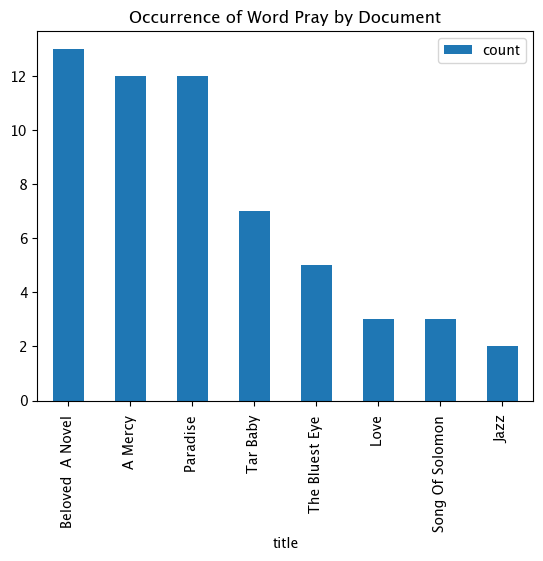

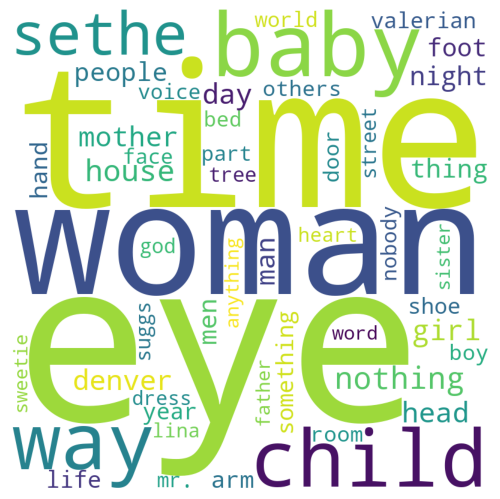

count
title             lem_token       
Beloved  A Novel  sethe         29
                  baby          28
                  denver        25
Paradise          woman         20
The Bluest Eye    eye           18
Tar Baby          valerian      15
Beloved  A Novel  house         12
                  suggs         12
                  thing         12
A Mercy           lina          11
                  man           11
Beloved  A Novel  arm           11
                  woman         11
Paradise          men           11
                  nothing       11
A Mercy           eye           10
Beloved  A Novel  girl          10
Paradise          child         10
                  head          10
                  sweetie       10

In [344]:
workset_id = '66477bae2600005807132b25'
search_term = 'pray'
data_framer(workset_id, search_term)